In [41]:
!apt-get install --fix-missing -y openjdk-11-jdk-headless -qq > /dev/null

In [42]:
import os
os.environ['JAVA_HOME'] = "/usr/lib/jvm/java-11-openjdk-amd64"

In [43]:
!pip install pyspark

In [44]:
#!pip install --upgrade pyarrow

In [45]:
!pip install fbprophet

In [46]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd 

from fbprophet import Prophet

mpl.rcParams['figure.figsize'] = (10,8)
mpl.rcParams['axes.grid'] = False

from pyspark.sql import SparkSession
import pyspark

In [47]:
spark = SparkSession.builder.master('local').getOrCreate()

In [48]:
df = pd.read_csv('https://raw.githubusercontent.com/srivatsan88/YouTubeLI/master/dataset/weekly_sales_data.csv')

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   date      500 non-null    object 
 1   store_id  500 non-null    int64  
 2   sales     500 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 11.8+ KB


In [50]:
df['date'] = pd.to_datetime(df['date'], infer_datetime_format=True)

In [51]:
print('Features :\n', df.columns.tolist())
print('\nMissing Values :\n', df.isnull().any())
print('\nUnique Values :\n', df.nunique())

Features :
 ['date', 'store_id', 'sales']

Missing Values :
 date        False
store_id    False
sales       False
dtype: bool

Unique Values :
 date         50
store_id     10
sales       500
dtype: int64


In [52]:
df_temp = df.copy()

In [53]:
df['store_id'].value_counts()

44    50
41    50
38    50
35    50
31    50
30    50
29    50
28    50
26    50
25    50
Name: store_id, dtype: int64

In [54]:
item_df = df.set_index('date')

In [55]:
sdf = spark.createDataFrame(df)

In [56]:
sdf.show(5)

+-------------------+--------+-----------+
|               date|store_id|      sales|
+-------------------+--------+-----------+
|2019-01-06 00:00:00|      25|736657.2267|
|2019-01-06 00:00:00|      26|   233711.0|
|2019-01-06 00:00:00|      28|692156.3794|
|2019-01-06 00:00:00|      29|   213706.8|
|2019-01-06 00:00:00|      30|   266455.0|
+-------------------+--------+-----------+
only showing top 5 rows



In [57]:
sdf.select(['store_id']).groupby('store_id').agg({'store_id':'count'}).show()

+--------+---------------+
|store_id|count(store_id)|
+--------+---------------+
|      26|             50|
|      29|             50|
|      31|             50|
|      25|             50|
|      41|             50|
|      28|             50|
|      44|             50|
|      35|             50|
|      38|             50|
|      30|             50|
+--------+---------------+



In [58]:
sdf.createOrReplaceTempView("sales")

In [59]:
sql = 'SELECT store_id, date as ds, sum(sales) as y FROM sales GROUP BY store_id, ds ORDER BY store_id, ds'

In [60]:
spark.sql(sql).show()

+--------+-------------------+------------------+
|store_id|                 ds|                 y|
+--------+-------------------+------------------+
|      25|2019-01-06 00:00:00|       736657.2267|
|      25|2019-01-13 00:00:00|       696457.1717|
|      25|2019-01-20 00:00:00|        996876.875|
|      25|2019-01-27 00:00:00|        1029737.05|
|      25|2019-02-03 00:00:00|       1072873.705|
|      25|2019-02-10 00:00:00|       880462.4681|
|      25|2019-02-17 00:00:00|        1088756.78|
|      25|2019-02-24 00:00:00|       1266928.313|
|      25|2019-03-03 00:00:00|       907510.1217|
|      25|2019-03-10 00:00:00|       747920.9824|
|      25|2019-03-17 00:00:00|       904750.3158|
|      25|2019-03-24 00:00:00|1069857.5890000002|
|      25|2019-03-31 00:00:00|       1195574.314|
|      25|2019-04-07 00:00:00|       834911.3333|
|      25|2019-04-14 00:00:00|       788777.4167|
|      25|2019-04-21 00:00:00|       849603.4333|
|      25|2019-04-28 00:00:00|        965521.165|


In [61]:
sdf.explain()

== Physical Plan ==
*(1) Scan ExistingRDD[date#1136,store_id#1137L,sales#1138]




In [62]:
sdf.rdd.getNumPartitions()

1

In [63]:
store_part = (spark.sql(sql).repartition(spark.sparkContext.defaultParallelism, ['store_id'])).cache()

In [64]:
store_part

DataFrame[store_id: bigint, ds: timestamp, y: double]

In [65]:
store_part.explain()

== Physical Plan ==
InMemoryTableScan [store_id#1137L, ds#1198, y#1199]
   +- InMemoryRelation [store_id#1137L, ds#1198, y#1199], StorageLevel(disk, memory, deserialized, 1 replicas)
         +- Exchange hashpartitioning(store_id#1137L, 1), REPARTITION_WITH_NUM, [id=#347]
            +- *(3) Sort [store_id#1137L ASC NULLS FIRST, ds#1198 ASC NULLS FIRST], true, 0
               +- Exchange rangepartitioning(store_id#1137L ASC NULLS FIRST, ds#1198 ASC NULLS FIRST, 200), ENSURE_REQUIREMENTS, [id=#343]
                  +- *(2) HashAggregate(keys=[store_id#1137L, date#1136], functions=[sum(sales#1138)])
                     +- Exchange hashpartitioning(store_id#1137L, date#1136, 200), ENSURE_REQUIREMENTS, [id=#339]
                        +- *(1) HashAggregate(keys=[store_id#1137L, date#1136], functions=[partial_sum(sales#1138)])
                           +- *(1) Scan ExistingRDD[date#1136,store_id#1137L,sales#1138]




In [66]:
from pyspark.sql.types import *

result_schema = StructType([
                            StructField('ds', TimestampType()),
                            StructField('store_id', IntegerType()),
                            StructField('y', DoubleType()),
                            StructField('yhat', DoubleType()),
                            StructField('yhat_lower', DoubleType()),
                            StructField('yhat_upper', DoubleType())
])

In [75]:
from pyspark.sql.functions import pandas_udf, PandasUDFType

@pandas_udf(result_schema, PandasUDFType.GROUPED_MAP)
def forecast_sales(store_pd):
  model = Prophet(interval_width=0.95, 
                  seasonality_mode = 'multiplicative',
                  weekly_seasonality=True, 
                  yearly_seasonality=True)
  
  model.fit(store_pd)

  future_pd = model.make_future_dataframe(
      periods=5,
      freq = 'w'
  )

  forecast_pd = model.predict(future_pd)

  f_pd = forecast_pd[['ds', 'yhat', 'yhat_upper', 'yhat_lower']].set_index('ds')
  st_pd = store_pd[['ds', 'store_id', 'y']].set_index('ds')

  results_pd = f_pd.join(st_pd, how='left')
  results_pd.reset_index(level=0, inplace=True)

  results_pd['store_id'] = store_pd['store_id'].iloc[0]

  return results_pd[ ['ds', 'store_id', 'y', 'yhat', 'yhat_upper', 'yhat_lower'] ]

In [76]:
from pyspark.sql.functions import current_date

results = (
    store_part.groupby('store_id').apply(forecast_sales).withColumn('training_date', current_date())
)

/usr/local/lib/python3.7/dist-packages/pyspark/sql/pandas/group_ops.py:84: UserWarning:

It is preferred to use 'applyInPandas' over this API. This API will be deprecated in the future releases. See SPARK-28264 for more details.



In [77]:
results.cache()

DataFrame[ds: timestamp, store_id: int, y: double, yhat: double, yhat_lower: double, yhat_upper: double, training_date: date]

In [78]:
results.show()

+-------------------+--------+------------------+------------------+------------------+------------------+-------------+
|                 ds|store_id|                 y|              yhat|        yhat_lower|        yhat_upper|training_date|
+-------------------+--------+------------------+------------------+------------------+------------------+-------------+
|2019-01-06 00:00:00|      25|       736657.2267| 712575.0694095818|473655.26172057027|  953197.814497732|   2021-05-02|
|2019-01-13 00:00:00|      25|       696457.1717| 743751.7568979745| 505490.9758820478| 980553.5191341601|   2021-05-02|
|2019-01-20 00:00:00|      25|        996876.875| 972909.8778074606| 733535.8793644882|1205047.2624788326|   2021-05-02|
|2019-01-27 00:00:00|      25|        1029737.05|1034447.5557655566| 785314.8696924116|1260907.1103557572|   2021-05-02|
|2019-02-03 00:00:00|      25|       1072873.705| 986365.7266813249| 748157.7948720506|1214837.1926313564|   2021-05-02|
|2019-02-10 00:00:00|      25|  

In [79]:
results.coalesce(1)

DataFrame[ds: timestamp, store_id: int, y: double, yhat: double, yhat_lower: double, yhat_upper: double, training_date: date]

In [80]:
results.count()

550

In [81]:
results.createOrReplaceTempView('forecasted')

In [85]:
final = results.toPandas()

In [86]:
final = final.set_index('ds')

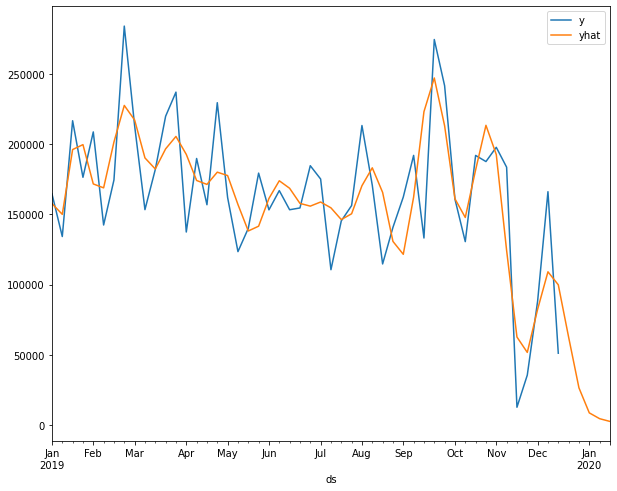

In [87]:
final.query('store_id==44')[['y','yhat']].plot()

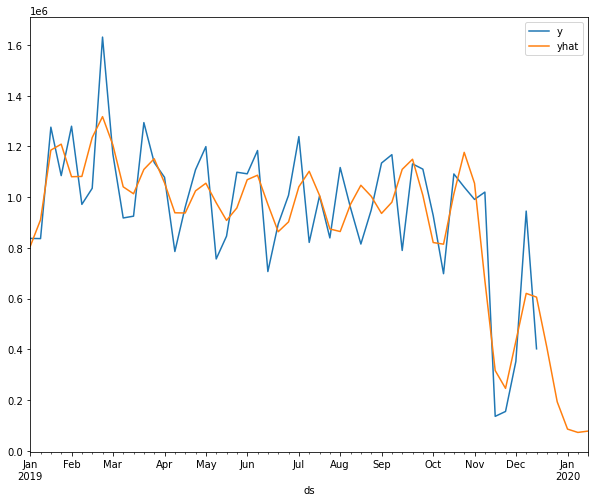

In [88]:
final.query('store_id==31')[['y','yhat']].plot()